# Predicting Titanic Survival with Decision Trees and Random Forests

- The goal of this project is to predict whether or not a passenger survived the Titanic. Decision Trees can be useful for addressing such classification problems and will be used alongside Random Forests to determine whether a passenger did or did not survive.
- Decision Trees work by splitting the data on a specific feature, with the specific feature being determined by which feature has the highest on criteria such as 'information gain' or the 'Gini index'. The data is then split further and further, depending on whether a data point meets a specified threshold for the feature the data is split on, before reaching a stopping point, such as a 'maximum tree depth'. 
- Random Forests combine multiple Decision Trees, with each tree being trained on a random subset of the training data and the features. Each data point is passed through each of the trees in the forest and the results are combined to return a prediction. The diversity across the different Decision Trees in a Random Forest can help improve model accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

### Data Exploration

In [2]:
titanic_data = pd.read_csv('Titanic Data.csv')

In [3]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- The describe() method returns some key statistics regarding the numerical columns in the DataFrame. The key take away from the ouput above, is that there are outliers in the 'Age' column and the 'Fare' column, where the maximum values are significantly larger than the upper quartile.

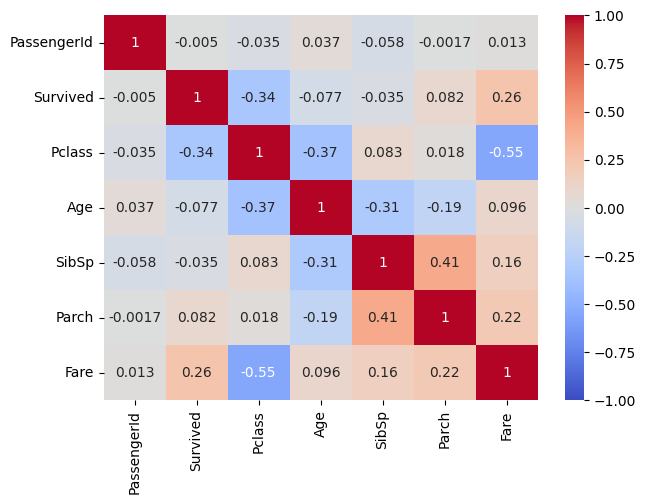

In [4]:
plt.figure(figsize=(7,5))
sns.heatmap(titanic_data.corr(numeric_only=True), vmax=1, vmin=-1, annot=True, cmap='coolwarm')
plt.show()

- The numeric variables that correlate most strongly with whether a passenger survived or not are the 'Pclass' and 'Fare' variables.

In [5]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- There are also null values in the 'Age', 'Cabin' and 'Embarked' column, which need to be handled

### Managing missing values

In [6]:
(len(titanic_data[titanic_data['Age'].isnull()]) / titanic_data.shape[0]) * 100

19.865319865319865

- Apprixmatley 20% of the values in the 'Age' column are null. There is sufficient data to not have to drop the column entirely and the null values can be filled.

In [7]:
median_age = titanic_data['Age'].median()
titanic_data['Age'].fillna(median_age, inplace=True)

In [8]:
(len(titanic_data[titanic_data['Cabin'].isnull()]) / titanic_data.shape[0]) * 100

77.10437710437711

- Approximately 77% of the values in the 'Cabin' column are null. Therefore, this column should be dropped as any imputation will be sourced from a small proportion of the data and is unlikely to be accurate.

In [9]:
titanic_data.drop(columns='Cabin', inplace=True)

In [10]:
titanic_data[titanic_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


- Examining the two rows where the 'Embarked' column is null, some similarities can be seen. Both passengers survived, were in the same ticket class ('Pclass') and were female. These similarities between the two passengers can be used to help decide how to fill in the null values in the 'Embarked' column

In [11]:
titanic_data[(titanic_data['Survived'] == 1) & (titanic_data['Pclass'] == 1) & (titanic_data['Sex'] == 'female')]['Embarked'].mode()[0]

'S'

- Selecting the rows where the passenger survived, their ticket was first class and they were female, the most common value for the 'Embarked' column in these rows was 'S' (signifying they embarked from the Southampton port), which will be used to impute the null values.

In [12]:
titanic_data['Embarked'] = titanic_data['Embarked'].fillna('S')

In [13]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Feature Engineering

In [14]:
male_female_survival = titanic_data.groupby('Sex').agg({'Survived':'mean'})
male_female_survival

,Survived
Sex,
female,0.742038
male,0.188908


- A higher proportion of females survived than males. The discrepancy between male and female survival rates suggests this feature to be a good feature for the Decision Tree and Random Forest models.

In [15]:
class_survival = titanic_data.groupby('Pclass').agg({'Survived':'mean'})
class_survival

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


- A higher proportion of first class ticket holders survived than second and third class ticket holders. Again, the variations demonstrated in survival rates indicate the 'Pclass' to be a suitable feature to include in the model.

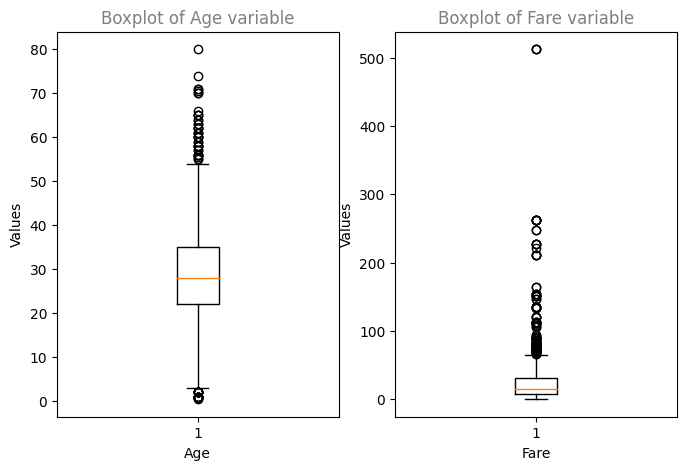

In [16]:
outlier_cols = ['Age', 'Fare']
fig = plt.figure(figsize=(8, 5))
for i, col in enumerate(outlier_cols):
    ax = fig.add_subplot(1, 2, i+1)
    ax.boxplot(titanic_data[col])
    ax.set_xlabel(col)
    ax.set_ylabel('Values')
    ax.set_title(f'Boxplot of {col} variable', alpha=0.5)
plt.tight_layout
plt.show()

- The boxplots of the 'Age' and 'Fare' variables indicate there are outliers with values significantly larger than the upper quartiles. As outliers can can distort data distribution and therefore reduce model accuracy, it would be useful to examine how the outliers are spread amogst the data and how to handle them. For the 'Age' variable, the scale at which the outliers are above the upper quartile is smaller than the the scale at which the outliers are above the upper quartile for the 'Fare' variable. Therefore, the variable will not need to be split as much to determine the correlation between the values within and not within the outlier range and the survival rate.

In [17]:
titanic_data_with_age_bins = titanic_data.copy()
titanic_data_with_age_bins['Age_Categories'] = titanic_data_with_age_bins['Age'].apply(lambda x : 'Below Outlier Range' if x < 56 else 'Above Outlier Range')

In [18]:
titanic_data_with_age_bins.groupby('Age_Categories').agg({'Survived':'mean'})

,Survived
Age_Categories,
Above Outlier Range,0.307692
Below Outlier Range,0.387324


- The output shows there is no significant difference in the survival rates between the passengers whose ages were above the outlier range and the passengers whose ages were below the outlier range. Given the similarity in survival rates, there is no problem with keeping the rows where the Age value is considered an outlier.

- For the 'Fare' variable, there are more values that lie in the outlier range. There is also more variation regarding the extent to which different values lie in the outlier range, compared to the 'Age' variable. Therefore, more bins will have to be used to exmamine how the outliers correlate to survival rates.

In [19]:
titanic_data_with_fares_bins = titanic_data.copy()
titanic_data_with_fares_bins['Fares_Categories'] = titanic_data_with_fares_bins['Fare'].apply(lambda x : 'Below Outlier Range' if x < 76  else 'Lowest Outliers' if x >= 76 and x < 200 else 'Middle Outliers' if x >= 200 and x < 300 else 'Highest Outliers')

In [20]:
titanic_data_with_fares_bins.groupby('Fares_Categories').agg({'Survived':'mean'})

,Survived
Fares_Categories,
Below Outlier Range,0.338365
Highest Outliers,1.000000
Lowest Outliers,0.776316
Middle Outliers,0.647059


- There are significant differences in the survival rates between the passengers at every category of the 'Fares_Categories' column, implying there is a correlation between whether a passenger's Fare value lies inside or outside the outlier range for the 'Fare' variable and the survival rate. The rows with the outliers need further examination.

In [21]:
titanic_data_with_fares_bins[titanic_data_with_fares_bins['Fares_Categories']=='Highest Outliers']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Fares_Categories
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C,Highest Outliers
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C,Highest Outliers
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C,Highest Outliers


- There are only three rows where the value in the 'Fare' column are at the high end of the outlier range. Removing these rows would not cause a significant loss in data, but also remove extreme outliers.

In [22]:
len(titanic_data_with_fares_bins[titanic_data_with_fares_bins['Fares_Categories']=='Middle Outliers'])

17

- There are also very few rows where the values in the 'Fare' column are in the middle range of the outliers. Therefore, these can also be removed.

In [23]:
len(titanic_data_with_fares_bins[titanic_data_with_fares_bins['Fares_Categories']=='Lowest Outliers'])

76

- There are signficantly more outliers at the lower end of the outlier range. As these outliers distort the distribution of the 'Fare' variable to a smaller extent than the higher and middle end outliers and removing these rows would equate to losing approximately 9% of the data, these rows will be kept in the DataFrame.

In [24]:
titanic_data = titanic_data.drop(titanic_data[titanic_data['Fare']>200].index)

In [25]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


- The 'PassengerId', 'Name' and 'Ticket' columns provide little predictive power regarding whether a passenger survived, as they are essentially all unique values and there are no real patterns to discern from them. Therefore, these columns will be removed. 

In [26]:
titanic_data.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

- The values in 'Sex' column are also in string form and cannot be used in a Decision Tree or Random Forest. As there are only two distinct vales in the column, the column can be encoded to represent females with a 1 and males with a 0.

In [27]:
titanic_data['Sex'] = titanic_data['Sex'].replace({'female':1, 'male':0})

In [28]:
titanic_data = pd.get_dummies(titanic_data, columns=['Embarked'], drop_first=True)

In [29]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,0,0
2,1,3,1,26.0,0,0,7.9250,0,1
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,1


- As there are several different units of measurement in the data, using a scaler can reduce the effect of different scales on the model, as it ensures all the features have the same scale.

In [30]:
scaler = StandardScaler()

### Creating the Models

In [31]:
X = pd.DataFrame(scaler.fit_transform(titanic_data.drop(columns=['Survived'])), columns=[col for col in titanic_data.columns if col != 'Survived'])
y = titanic_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
dt_model = DecisionTreeClassifier()

- Setting up a Grid Search can help with model accuracy, as it allows for the mixing of different hyperparameters to create multiple models, before selecting the set of hyperparameters which produced the most accurate model. In the case of Decision Trees or Random Forests, some useful hyperparameters to manipulate can be the criteria set to split the data, the maximum depth of the tree and the number of Trees used in a Random Forest.

In [33]:
dt_params = {'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':[3, 4, 5]}

In [34]:
dt_grid = GridSearchCV(estimator=dt_model, param_grid=dt_params, scoring='accuracy', cv=2, verbose=3)

In [35]:
dt_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END .......criterion=gini, max_depth=3;, score=0.828 total time=   0.0s
[CV 2/2] END .......criterion=gini, max_depth=3;, score=0.787 total time=   0.0s
[CV 1/2] END .......criterion=gini, max_depth=4;, score=0.793 total time=   0.0s
[CV 2/2] END .......criterion=gini, max_depth=4;, score=0.796 total time=   0.0s
[CV 1/2] END .......criterion=gini, max_depth=5;, score=0.816 total time=   0.0s
[CV 2/2] END .......criterion=gini, max_depth=5;, score=0.796 total time=   0.0s
[CV 1/2] END ....criterion=entropy, max_depth=3;, score=0.782 total time=   0.0s
[CV 2/2] END ....criterion=entropy, max_depth=3;, score=0.782 total time=   0.0s
[CV 1/2] END ....criterion=entropy, max_depth=4;, score=0.807 total time=   0.0s
[CV 2/2] END ....criterion=entropy, max_depth=4;, score=0.793 total time=   0.0s
[CV 1/2] END ....criterion=entropy, max_depth=5;, score=0.802 total time=   0.0s
[CV 2/2] END ....criterion=entropy, max_depth=5;,

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 4, 5]},
             scoring='accuracy', verbose=3)

In [36]:
dt_grid.best_params_

{'criterion': 'log_loss', 'max_depth': 4}

In [37]:
decision_tree = DecisionTreeClassifier(**dt_grid.best_params_)
decision_tree.fit(X_train, y_train)
dt_predictions = decision_tree.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)

print(dt_accuracy)

0.7771428571428571


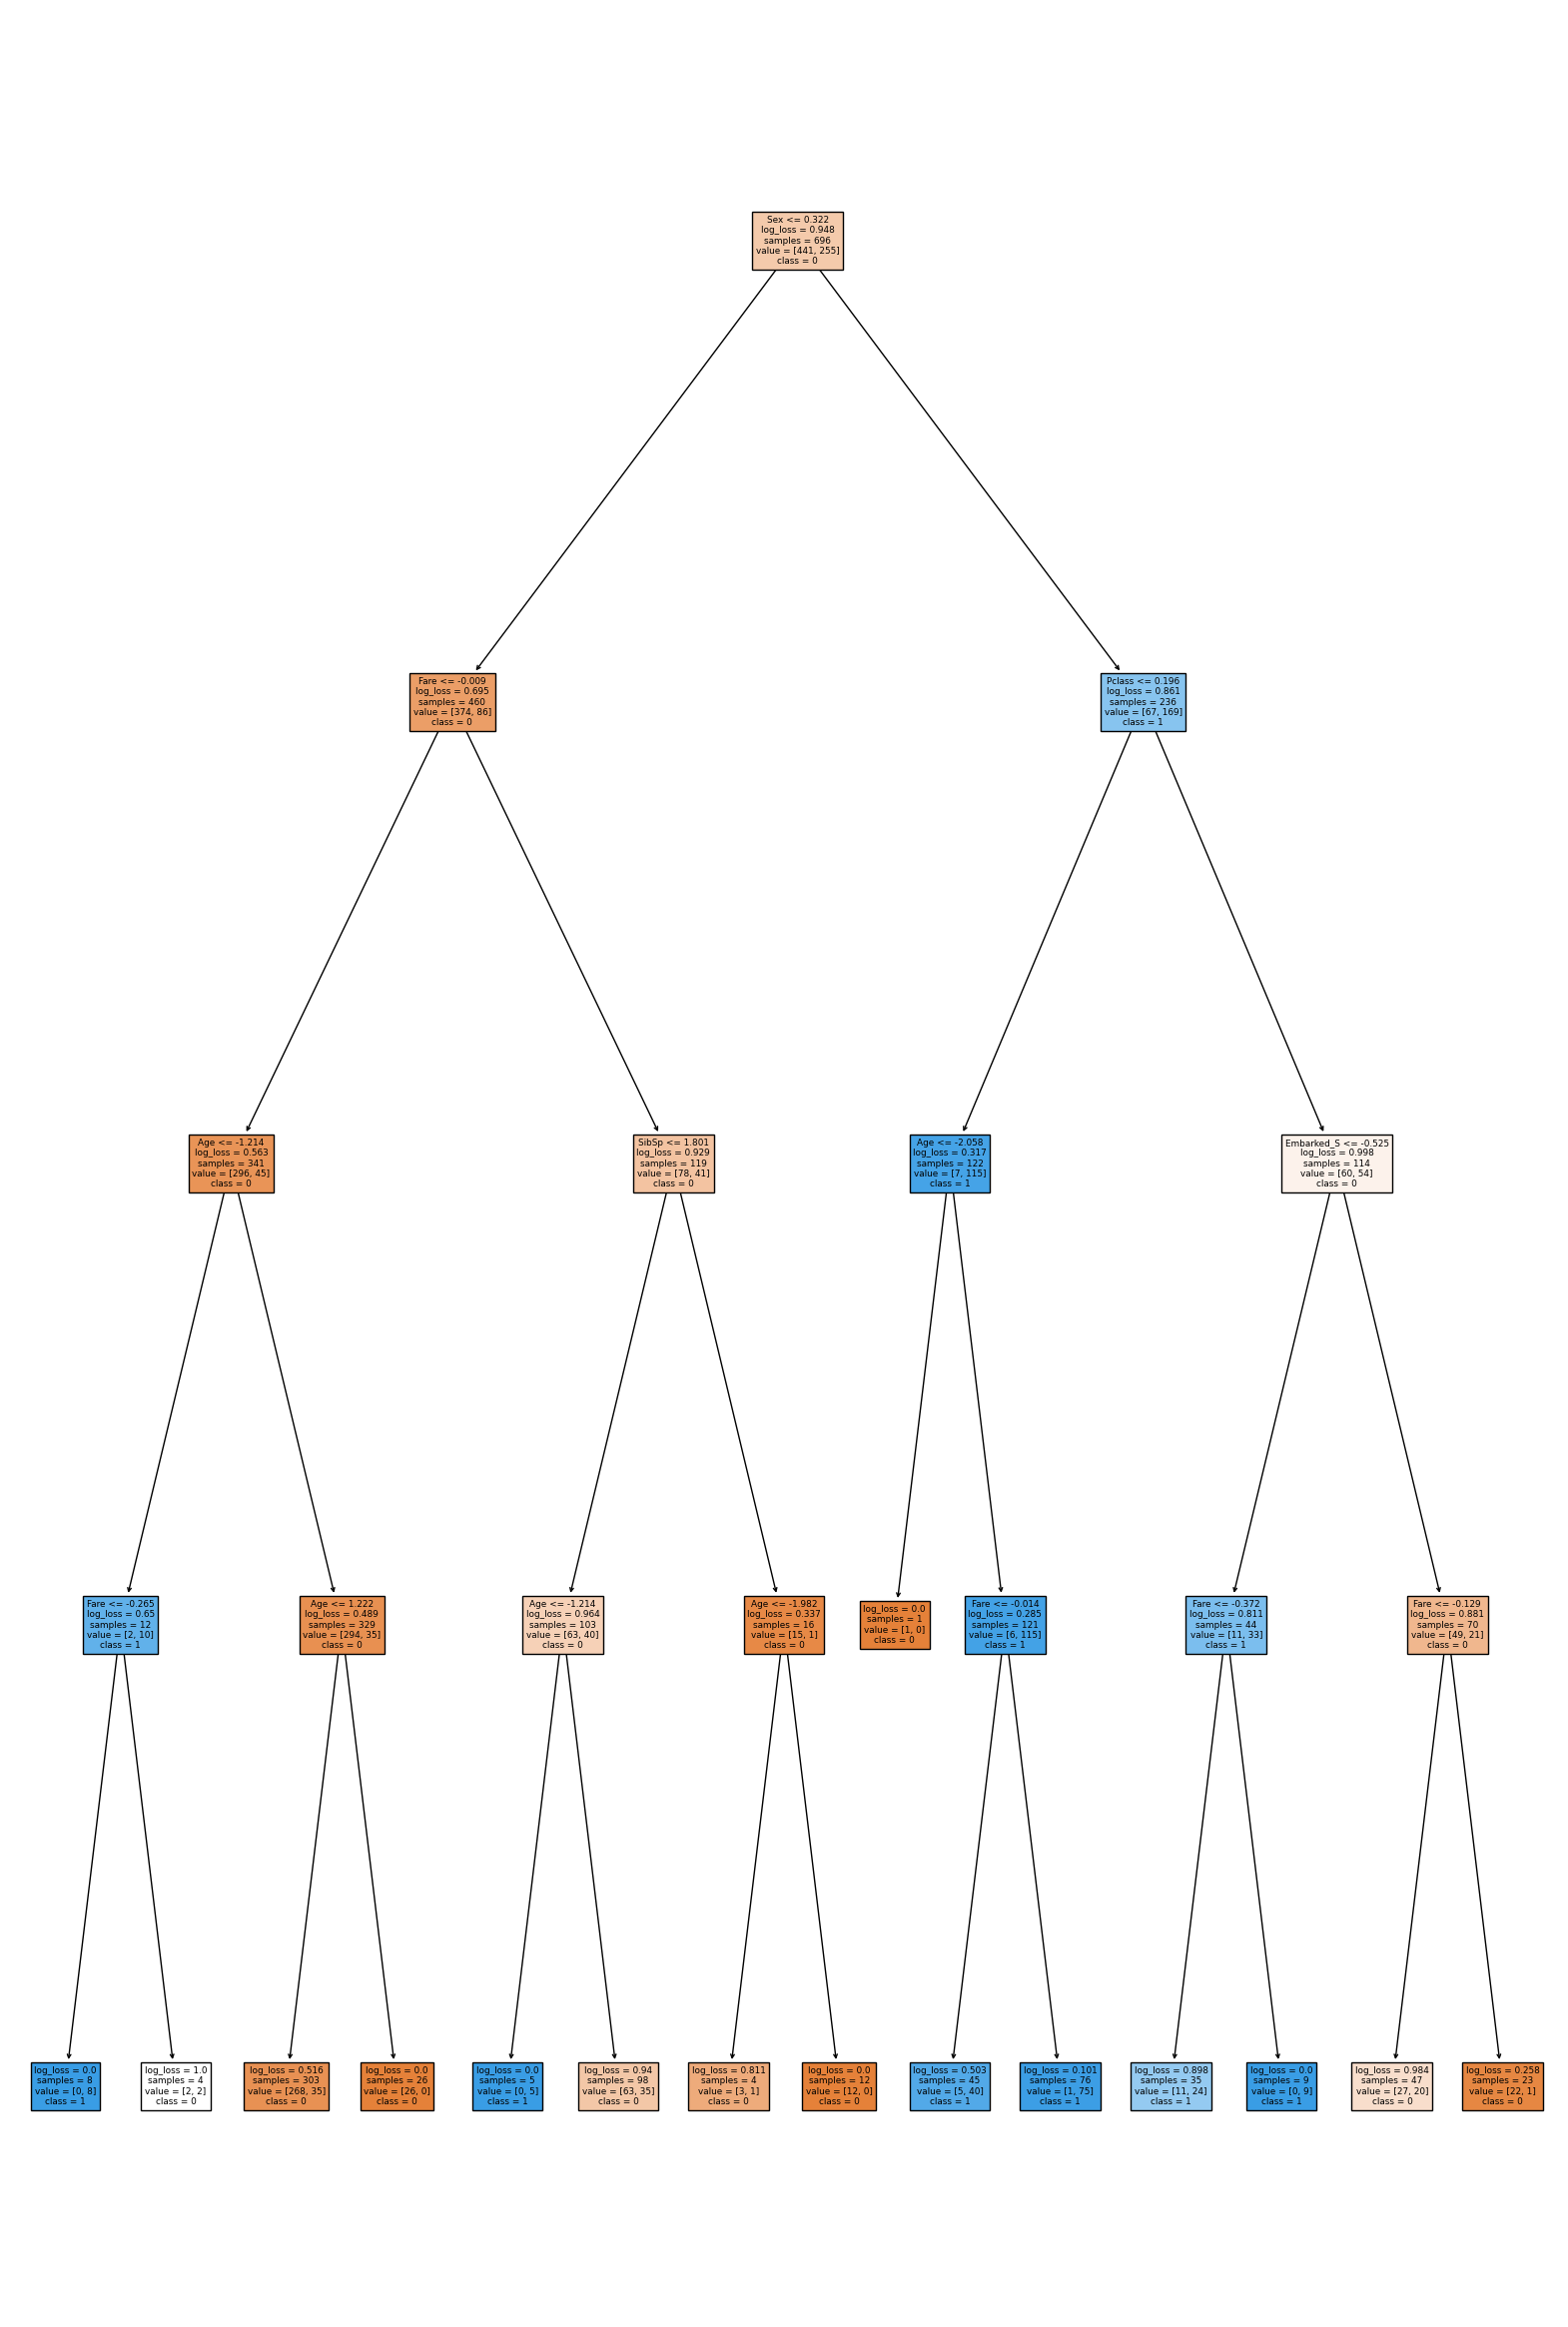

In [38]:
plt.figure(figsize=(20, 30))
plot_tree(decision_tree, feature_names=X_train.columns, class_names=y_train.unique().astype(str), filled=True)
plt.show()

- Using a single Decision Tree, an accuracy of approximately 78% was achieved. Using a Random Forest could improve the accuracy of predicting Titanic survival however, as Random Forests can help in reducing overfitting of the model and are able to capture more relationships in the data, due to a greater variety of subsets in the data being used for training and testing.

In [39]:
rf_params = {'n_estimators':[50,100,150,200,500], 'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':[3,4,5]}

In [40]:
rf_model = RandomForestClassifier()

In [41]:
rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_params, scoring='accuracy', cv=2, verbose=3)

In [42]:
rf_grid.fit(X_train, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits
[CV 1/2] END criterion=gini, max_depth=3, n_estimators=50;, score=0.816 total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=3, n_estimators=50;, score=0.810 total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=3, n_estimators=100;, score=0.828 total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=3, n_estimators=100;, score=0.799 total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=3, n_estimators=150;, score=0.851 total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=3, n_estimators=150;, score=0.802 total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=3, n_estimators=200;, score=0.851 total time=   0.1s
[CV 2/2] END criterion=gini, max_depth=3, n_estimators=200;, score=0.793 total time=   0.1s
[CV 1/2] END criterion=gini, max_depth=3, n_estimators=500;, score=0.845 total time=   0.4s
[CV 2/2] END criterion=gini, max_depth=3, n_estimators=500;, score=0.802 total time=   0.4s
[CV 1/2] END criterio

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 500]},
             scoring='accuracy', verbose=3)

In [43]:
rf_grid.best_params_

{'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 100}

In [46]:
random_forest = RandomForestClassifier(**rf_grid.best_params_)
random_forest.fit(X_train, y_train)
random_forest_predictions = random_forest.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
print(random_forest_accuracy)

0.8


- Overall, the Random Forest model improved the accuracy of the predictions by slightly over 2%. Considering the extra computational power needed to achieve the improvement in accuracy, where the Random Forest models took approximately 17 more seconds to fit onto the data, using a Decision Tree for this classification problem would be most efficient. However, other classification models, such as a Logistic Regression model, a Naive Baye's model or an ADA bossting classifier could have seen further improvements in accuracy, without using significant extra computational power.